In [20]:
import copy
from typing import Callable
from dataclasses import dataclass

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams["figure.dpi"] = 100
from perlin_noise import PerlinNoise

from PointSystem import PointSystem
from scipy.spatial import Delaunay

from sympy.geometry import Point, Circle

from scipy.optimize import fsolve

In [ ]:
def ExplicitRungeKuttaFourthOrder(f: callable, X: np.array, dt: float):
    
    k1 = f(X.copy())
    k2 = f(X.copy() + k1 * dt / 2)
    k3 = f(X.copy() + k2 * dt / 2)
    k4 = f(X.copy() + k3 * dt)
    X += dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    # X += 

    N = X.shape[0] // 4
    
    X[0] = 0
    X[1] = 1
    X[2] = 0
    X[3] = 1
    
    X[0 + 2*N] = 0
    X[1 + 2*N] = 0
    X[2 + 2*N] = 1
    X[3 + 2*N] = 1

    for i in range(0, N):
        if X[i] > 1:
            X[i] = 1
        if X[i] < 0:
            X[i] = 0

    for i in range(2*N, 3*N):
        if X[i] > 1:
            X[i] = 1
        if X[i] < 0:
            X[i] = 0

    return X

In [40]:
# f = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100
noise_generator = PerlinNoise(octaves=2, seed=1)
f = lambda point: noise_generator(point) * 50 + 30
import plotly.graph_objects as go
n, m = 100, 100

# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
noise = np.array([[f(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])

fig = go.Figure(data=[
    go.Surface(z=noise)
    ])
fig.update_layout(title='surface', autosize=False,
                  width=500, height=500,
                  margin=dict(l=65, r=50, b=65, t=90))

fig.show()

In [50]:
def borderF(f: Callable[[float, float], float], x: float):
    if x < 1:
        return f(x, 0)
    elif 1 <= x < 2:
        return f(1, x - 1)
    elif 2 <= x < 3:
        return f(x - 2, 1)
    elif 3 <= x <= 4:
        return f(0, x - 3)
    else:
        return borderF(f, x - 4)
        # raise ValueError('Out of range')

def NewtonRootFinder(f: Callable[[float], float], x0: float, Df: Callable[[float], float] = None, eps=10e-4, maxIterations=1000):
    if Df is None: Df = lambda x: (f(x + eps/2) - f(x - eps/2)) / eps
    x = x0
    for n in range(0, maxIterations):
        fx = f(x)
        if abs(fx) < eps:
            return x
        Dfx = Df(x)
        if Dfx == 0:
            return None
        x -= fx/Dfx
    return None

# f = lambda x: np.exp((-np.power(np.linalg.norm(np.array([x])-2.5), 2)) / (0.5/1)**2) * 10 + 1
a = 0
b = 5
d0 = 10000

def F(w):
    global a, b, d0, f
    return_function = np.zeros(len(w))
    return_function[0] = w[0] - a - min(w[-1]/f((a+w[0])/2), d0)
    return_function[-1] = b - w[-2] - min(w[-1]/f((b+w[-2])/2), d0)
    for i in range(1, len(w) - 1):
        return_function[i] = w[i] - w[i-1] - min(w[-1]/f((w[i] + w[i-1])/2), d0)
    return return_function

def J(f, x, dx=1e-10):
    n = len(x)
    func = f(x)
    jac = np.zeros((n, n))
    for j in range(n):  # through columns to allow for vector addition
        Dxj = (abs(x[j])*dx if x[j] != 0 else dx)
        x_plus = [(xi if k != j else xi + Dxj) for k, xi in enumerate(x)]
        jac[:, j] = (f(x_plus) - func)/Dxj
    return jac

def NewtonSystemRootsFinder(F, w0, eps = 10e-4, maxIterations : int = 1000):
    w = w0.copy()
    last_w = w0.copy()
    for n in range(0, maxIterations):
        jacobian = J(F, w)
        w = w - np.dot(np.linalg.inv(jacobian),F(w))
        if np.linalg.norm(w - last_w) < eps:
            return w
        else:
            last_w = w.copy()
    return None


def makeGrid(F, f: Callable[[float], float], a, b):
    global d0
    x = a
    grid: list[float] = list()
    while x < b:
        grid.append(x)
        x = NewtonRootFinder(lambda xi: xi - x - min(2. / f((xi + x) / 2), d0), x)
    grid.append(2.)
    w0 = np.delete(np.array(grid), 0)
    # grid_with_alpha = NewtonSystemRootsFinder(F, w0)
    grid_with_alpha = fsolve(F, w0)

    alpha = grid_with_alpha[len(grid_with_alpha) - 1]
    return_grid = np.insert(grid_with_alpha[:len(grid_with_alpha) - 1], 0, a)
    return_grid = np.append(return_grid, b)
    
    return return_grid, alpha


1.990556776464756
75


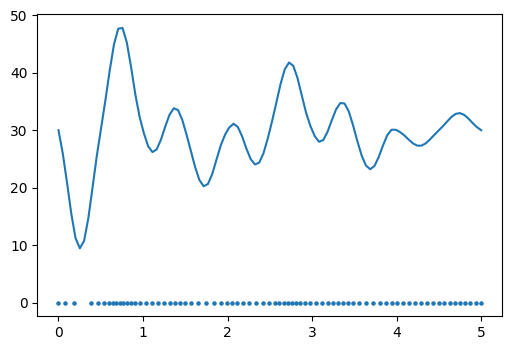

In [51]:
grid, alpha = makeGrid(F, f, a, b)
print(alpha)
print(len(grid))
X = np.linspace(a, b, 100)
plt.scatter(grid, np.zeros(len(grid)), s=5)
plt.plot(X, np.vectorize(f)(X))
plt.show()

In [52]:
f = lambda x, y: np.exp((-np.power(np.linalg.norm(np.array([x, y])-0.5), 2)) / (0.5/2)**2) * 10
grid = makeGrid(lambda x: borderF(f, x), 0, 4, 0.001)
X = np.linspace(0, 4, 1000)
plt.scatter(grid, np.zeros(len(grid)))
plt.plot(X, np.vectorize(lambda x: borderF(f, x))(X))
plt.show()

Error: Canceled future for execute_request message before replies were done

In [ ]:
a = np.array([np.random.rand(3), np.random.rand(3)])
a, a.transpose()

(array([[0.45709788, 0.65146062, 0.16142628],
        [0.45639403, 0.93373457, 0.81426182]]),
 array([[0.45709788, 0.45639403],
        [0.65146062, 0.93373457],
        [0.16142628, 0.81426182]]))

In [ ]:
def F(X: np.array) -> np.array:
    global edges_dict, noise_generator

    # f = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100 + 1
    f = lambda point: noise_generator(point) * 10 + 6

    N: int = X.shape[0] // 4

    xs = X[:N]
    vxs = X[N:2*N]
    ys = X[2*N:3*N]
    vys = X[3*N:4*N]

    new_vxs = np.zeros((N))
    new_vys = np.zeros((N))
    
    for i in range(0, N):
        for j in range(0, N):
            if i != j:
                try:
                    if j in edges_dict[i]:
                        xa, ya = xs[j], ys[j]
                        xb, yb = xs[i], ys[i]
                        middleX = (xa + xb) / 2
                        middleY = (ya + yb) / 2
                        distance = np.sqrt(np.power(xa - xb, 2) + np.power(ya - yb, 2))
                        d0 = 1 / f(np.array([middleX, middleY]))
                        K = 100
                        if distance > d0:
                            # if distance > np.pi * d0:
                            #     continue
                            new_vxs[i] += K * (xa - xb)/1#f(np.array([middleX, middleY])) / 100
                            new_vys[i] += K * (ya - yb)/1#f(np.array([middleX, middleY])) / 100
                        else:
                            new_vxs[i] += -K * (xa - xb)/1#/f(np.array([middleX, middleY])) / 100
                            new_vys[i] += -K * (ya - yb)/1#/f(np.array([middleX, middleY])) / 100
                except:
                    xxxxxx = 1
    
    for i in range(0, N):
        xs[i] = vxs[i]
    
    for i in range(0, N):
        ys[i] = vys[i]

    return np.concatenate(
        (
            xs,
            new_vxs,
            ys,
            new_vys
        )
    )

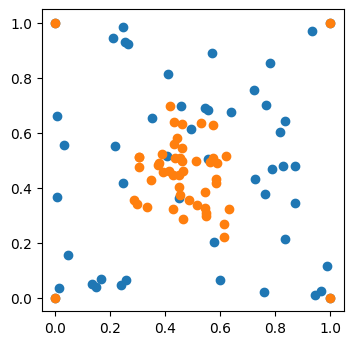

In [ ]:
N = 50
# X = np.concatenate(
#     (
#         np.random.rand(N),# np.array([1/4 * np.cos(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
#         np.random.rand(N)/100,
#         np.random.rand(N),# np.array([1/4 * np.sin(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
#         np.random.rand(N)/100
#     )
# )
X = np.concatenate(
    (
        np.array([0, 1, 0, 1]),
        np.random.rand(N - 4),# np.array([1/4 * np.cos(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
        np.zeros(4),
        np.random.rand(N - 4)/100,
        np.array([0, 0, 1, 1]),
        np.random.rand(N - 4),# np.array([1/4 * np.sin(phi) + 1/2 for phi in np.linspace(0, 2*np.pi, N)]),
        np.zeros(4),
        np.random.rand(N - 4)/100
    )
)
plt.scatter(X[0:N], X[2*N:3*N])
# plt.gca().set_aspect('equal', adjustable='box')

T = 1
dt = 0.01

Fs = list()
Fs.append(X.copy())
t = 0

xs = X[:N]
ys = X[2*N:3*N]
points = np.array([xs, ys]).transpose()
tri = Delaunay(points)
_, edges_dict = PointSystem.calculateEdges(tri)

while t < T:
    X = ExplicitRungeKuttaFourthOrder(F, X.copy(), dt)
    Fs.append(X.copy())
    t += dt

X = Fs[-1]
plt.scatter(X[0:N], X[2*N:3*N])
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Fs

In [ ]:
from celluloid import Camera

n, m = 100, 100
# ng = lambda i, j: noise_generator([i/n, j/m]) * 10 + 6
# noise = np.array([[ng(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])
extent = [0, 1, 0, 1]
fig = plt.figure(dpi = 300)
# im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')

plt.gca().set_aspect('equal', adjustable='box')

camera = Camera(fig)
for i, X in enumerate(Fs[:]):
    if i % 10 == 0:
        # tri = ps[0].triangulation
        # points = ps[0].points
        # plt.triplot(points[:,0], points[:,1], tri.simplices, color='grey')
        # print(X)
        t = plt.plot(X[0:N], X[2*N:3*N], 'o', color='black')
        # im = plt.imshow(noise, extent=extent, cmap='RdBu', interpolation='nearest')
        # plt.colorbar(im)
        plt.legend(t, [f'#{i}'], loc='upper center', bbox_to_anchor=(0.5, -0.05))
        camera.snap()

animation = camera.animate()
animation.save('evolution_animation.gif')

ModuleNotFoundError: No module named 'celluloid'

In [ ]:
@dataclass
class vectorFunction:
    variables: list[str]
    functions: list[callable]

    def __init__(self, variables, functions):
        if len(variables) != len(functions):
            raise ValueError("variables and functions list size don't match")
        
        self.variables = variables
        self.functions = functions
    
    def __call__(self, X):
        return np.array([f(X) for f in self.functions])

In [ ]:
s = 10
r = 28
b = 8/3
f = lambda x, y, z: s*(y-x)
fs = vectorFunction(['x', 'y', 'z'], [lambda point: s*(point[1]-point[0]), lambda point: point[0]*(r-point[2])-point[1], lambda point: point[0]*point[1]-b*point[2]])
fs(np.array([0.1, 0.1, 0.1]))

array([ 0.        ,  2.69      , -0.25666667])

In [ ]:
f = lambda point: np.sin(point)

X = np.array([0.1, 0.1, 0.1])

T = 25
dt = 0.01

F = list()
F.append(X)
t = 0
while t < T:
    F.append(ExplicitRungeKuttaFourthOrder(fs, F[-1].copy(), dt))
    t += dt

plt.plot(np.linspace(0, T, int(T/dt) + 1), F)
plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 3

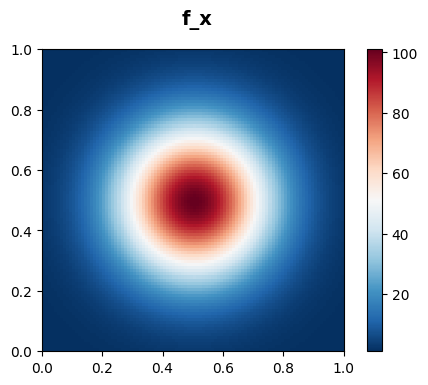

In [ ]:
n = 100
extent = [0, 1, 0, 1]

f_x = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100 + 1

speed_x = np.array([[v_y(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])

im = plt.imshow(noise, extent=extent, cmap='RdBu_r', interpolation='nearest')
plt.colorbar(im)
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle('f_x', fontsize=14, fontweight='bold')
plt.show()

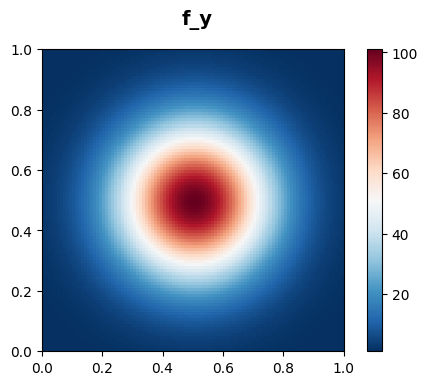

In [ ]:
n = 100
extent = [0, 1, 0, 1]

f_y = lambda point: np.exp((-np.power(np.linalg.norm(point-0.5), 2)) / (0.5/2)**2) * 100 + 1

speed_y = np.array([[v_y(np.array([i/n, j/n])) for j in range(n)] for i in range(n)])

im = plt.imshow(noise, extent=extent, cmap='RdBu_r', interpolation='nearest')
plt.colorbar(im)
plt.gca().set_aspect('equal', adjustable='box')
plt.suptitle('f_y', fontsize=14, fontweight='bold')
plt.show()

In [3]:
def J(f1, f2, point, eps=10e-4):
    Df_x = lambda f, x, y : (f(x+eps, y) - f(x-eps, y))/(2*eps)
    Df_y = lambda f, x, y : (f(x, y+eps) - f(x, y-eps))/(2*eps)
    return np.array([[Df_x(f1, point[0], point[1]), Df_y(f1, point[0], point[1])],
                    [Df_x(f2, point[0], point[1]), Df_y(f2, point[0], point[1])]])

def NewtonSystemRootFinder(f1: Callable[[float, float], float], f2: Callable[[float, float], float], point_0: tuple[float, float], eps=10e-4, maxIterations=1000):
    point = point_0
    for n in range(0, maxIterations):
        new_point = point - np.linalg.inv(J(f1, f2, point)).dot(np.array([f1(point[0], point[1]), f2(point[0], point[1])]))
        if np.linalg.norm(new_point-point) < eps:
            return new_point
        else:
            point = new_point
    return None

[0.29556856 0.14046714]


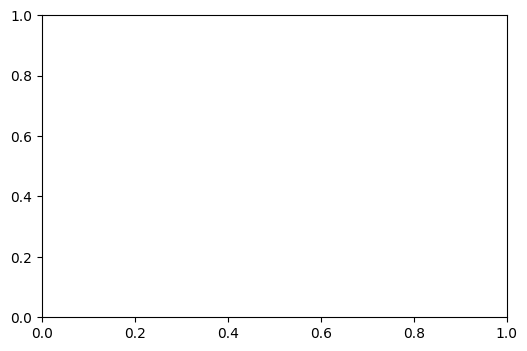

In [37]:
point_1 = np.array([0.2, 0])
point_2 = np.array([0.22600352, 0.15589985])
points = np.array([[0.06056214,0.16119367],[0,0],[0.1, 0], [1, 0], [0, 1], [1, 1], [0.2, 0], [0.15774428, 0.15553251], [0.22600352, 0.15589985], [0.3, 0], [0.29556856, 0.14046714]])
f = lambda x, y : np.exp(-(x-0.5)**2 -(y-0.5)**2 / (0.5/2)**2) * 100 + 1
f1 = lambda x, y : np.sqrt((x-point_1[0])**2 + (y-point_1[1])**2) - 1/f((x+point_1[0])/2, (y+point_1[1])/2)
f2 = lambda x, y : np.sqrt((x-point_2[0])**2 + (y-point_2[1])**2) - 1/f((x+point_2[0])/2, (y+point_2[1])/2)

print(NewtonSystemRootFinder(f1, f2, np.array([0.05,0])+ (point_1+point_2)/2))

p1 = [0.1, 0]
p2 = [0,0]
p3 = [0.06056214,0.16119367]
c2 = Circle(Point(p1[0], p1[1]), Point(p2[0], p2[1]), Point(p3[0], p3[1]))
circle = plt.Circle(с2.center, c2.radius, color = 'b', fill = False)
ax = plt.gca()
ax.add_patch(circle)
plt.scatter(points.transpose()[0], points.transpose()[1])
plt.axis('scaled')
